In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import matplotlib.ticker as plticker

## California Department of Managed Health Care's Independent Medical Reviews

The data is from the California Department of Managed Health Care (DMHC). It contains over 28,000 decisions from IMRs administered by the DMHC since January 1, 2001. An IMR is an independent review of a denied, delayed, or modified health care service that the health plan has determined to be not medically necessary, experimental/investigational, or non-emergent/urgent. If the IMR is decided in an enrollee’s favor, the health plan must authorize the service or treatment requested.

The are 14 total features, e.g. patient age/gender, diagnosis, and treatment.

### Data Pre-processing


In [2]:
imr = pd.read_csv('data/imr_trends.csv')

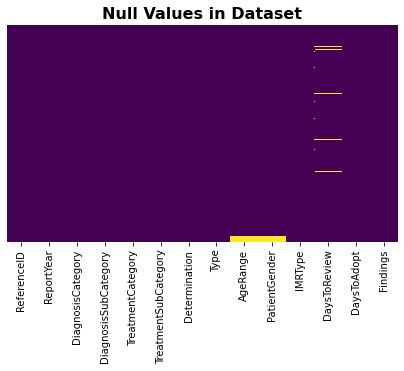

In [3]:
# Identify null values.
# 'Treatment SubCategory' and 'DiagnosisSubcategory' are missing 2 values.
# 'AgeRange' and 'PatientGender' are missing 685 values.
# 'DaysToReview' is missing 663 values.
plt.figure(figsize=(7,4))
sns.heatmap(imr.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Null Values in Dataset', fontsize=16, fontweight='bold');

---
## Handling Missing Data

Avg. Days to Review: 17.0
Median Days to Review: 19.0


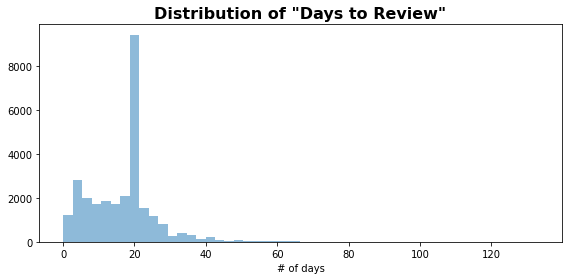

In [4]:
# HISTOGRAM OF DAYS TO REVIEW
# Suspect that the arbitrators have a deadline of 21 days/3 weeks to complete the review.
# Since the data is skewed, fill in null values with the median.

# Remove NaNs to plot distribution.
arr_days = np.array(imr['DaysToReview'])
arr_days_no_nan = arr_days[~np.isnan(arr_days)]

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(arr_days_no_nan, bins=50, alpha=0.5)
ax.set_title('Distribution of "Days to Review"', fontsize=16, fontweight='bold')
ax.set_xlabel('# of days')
plt.tight_layout();

print('Avg. Days to Review: {:.1f}'.format(imr['DaysToReview'].mean()))
print('Median Days to Review: {:.1f}'.format(imr['DaysToReview'].median()))

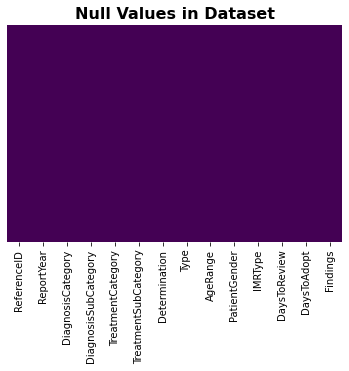

In [5]:
# Apply the median of "DaysToReview" to fill missing values within the feature.
# After filling in the "DaysToReview", there are 689 remaining missing values, 2.3% of initial dataset, .
# Discard observations that include the remaining null values.
imr['DaysToReview'].fillna(imr['DaysToReview'].median(), inplace=True)
imr2 = imr.dropna(axis=0)
sns.heatmap(imr2.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Null Values in Dataset', fontsize=16, fontweight='bold');

---
## Exploratory Data Analysis


### Analyze Annual Trend of Overturn Rate

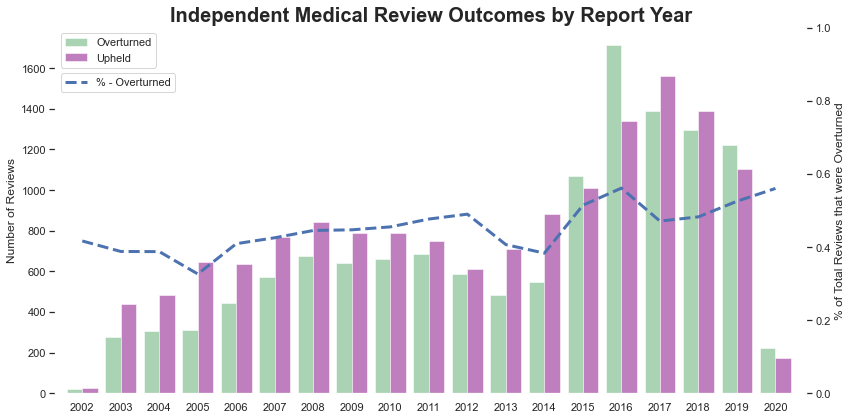

In [31]:
# Deliniated by 'Determination'
yr_grpd_1 = imr2.groupby(['ReportYear', 'Determination']).agg({'Determination':'count'})
yr_grpd_1.columns = ['count']
yr_grpd_1.reset_index(inplace=True)
yr_ovrtrnd = yr_grpd_1[yr_grpd_1['Determination'] == 'Overturned Decision of Health Plan']
yr_upheld = yr_grpd_1[yr_grpd_1['Determination'] == 'Upheld Decision of Health Plan']

# Total "Determinations" per year.
yr_grpd_2 = imr2.groupby(['ReportYear']).agg({'Determination':'count'})
yr_grpd_2.columns = ['count']
yr_grpd_2.reset_index(inplace=True)

# Merge
det_yr = pd.merge(yr_grpd_2, yr_ovrtrnd, how='left', on='ReportYear')
det_yr = pd.merge(det_yr, yr_upheld, how='left', on='ReportYear')
det_yr.rename({'count_x':'total_reviewed', 'count_y':'num_overturned', 'count':'num_upheld'}, axis=1, inplace=True)
det_yr.drop(['Determination_x', 'Determination_y'], inplace=True, axis=1)
det_yr['percent_overturned'] = det_yr['num_overturned'] / det_yr['total_reviewed'].astype(np.float)
det_yr.fillna(0, inplace=True)
det_yr.drop(0, axis=0, inplace=True)

pos = list(range(len(det_yr['ReportYear'])))
width = 0.4

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(pos, det_yr['num_overturned'], width, alpha=0.5, color='g', label='Overturned')
ax1.bar([p + width for p in pos], det_yr['num_upheld'], width, alpha=0.5, color='purple', label='Upheld')
ax1.set_ylabel('Number of Reviews')
ax1.set_xticks([p + 0.5 * width for p in pos])
ax1.set_xticklabels(det_yr['ReportYear'])
ax1.set_title('Independent Medical Review Outcomes by Report Year', fontsize=20, fontweight='bold')

ax1.set_xlim(-0.5, 19)

ax1.legend(loc='upper left', facecolor='white')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(color=None, linestyle='None')
ax1.set_facecolor('white')
plt.rcParams['font.family'] = 'arial'

# Share x-axis
ax2=ax1.twinx()

ax2.set_ylabel('% of Total Reviews that were Overturned')
ax2.set_ylim(0,1)
ax2.plot([p + width/2 for p in pos], det_yr['percent_overturned'], color='b', linestyle='--', linewidth=3, 
         label='% - Overturned')

ax2.legend(bbox_to_anchor=(0, 0, 0.167, 0.89), facecolor='white')
ax2.grid(color=None, linestyle='None')
plt.tight_layout();

#fig.savefig('images/annual_trend.png')

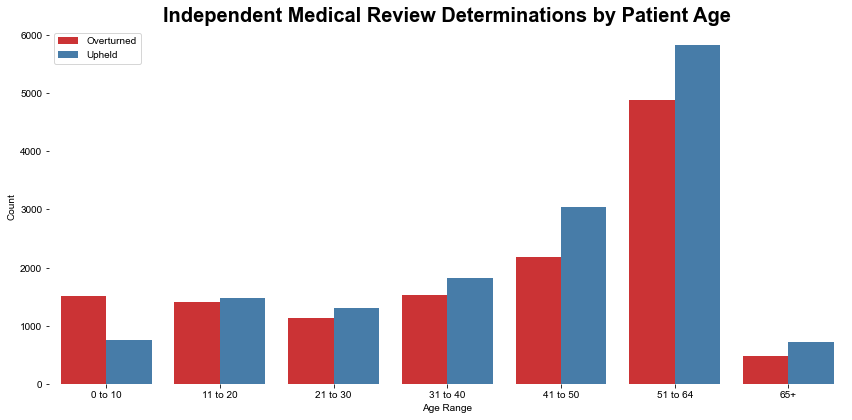

In [7]:
# Determination by Age
# At a glance, it seems like the younger the patient, the more likely the the health plan's decision was overturned.
fig, ax = plt.subplots(figsize=(12,6))
age_order = ['0 to 10', '11 to 20', '21 to 30', '31 to 40', '41 to 50', '51 to 64', '65+']
g = sns.countplot(x='AgeRange', data=imr2, order = age_order, hue='Determination', palette='Set1')
g.legend().set_title(None)
g.legend(['Overturned', 'Upheld'],facecolor='white', loc = 'upper left')
g.set(xlabel='Age Range', ylabel='Count')
g.set_title("Independent Medical Review Determinations by Patient Age", fontsize=20, fontweight='bold')
sns.despine(top=True, bottom=True, left=True, right=True)
sns.set(font='Arial')

# Formatting hack to resolve "grey facecolor and grid lines" default setting.
g.grid(color=None, linestyle='None')
g.set_facecolor('white')

plt.tight_layout();
#fig.savefig('images/age.png')

In [8]:
# Calculate the the values that accompany the chart above.
age_grpd = imr2.groupby(['AgeRange', 'Determination']).agg({'Determination':'count'}).unstack()

age_grpd.rename({'Overturned Decision of Health Plan': 'overturned', 'Upheld Decision of Health Plan':'upheld'},
                axis=1, inplace=True)
age_grpd.reset_index(inplace=True, col_level=1)
age_grpd = age_grpd.droplevel(0, axis=1)
age_grpd['prcnt_overturned'] = age_grpd['overturned'] / (age_grpd['overturned'] + age_grpd['upheld'])
age_grpd

Determination,AgeRange,overturned,upheld,prcnt_overturned
0,0 to 10,1506,752,0.666962
1,11 to 20,1413,1484,0.487746
2,21 to 30,1124,1303,0.463123
3,31 to 40,1529,1829,0.455331
4,41 to 50,2180,3039,0.417705
5,51 to 64,4887,5836,0.455749
6,65+,486,716,0.404326


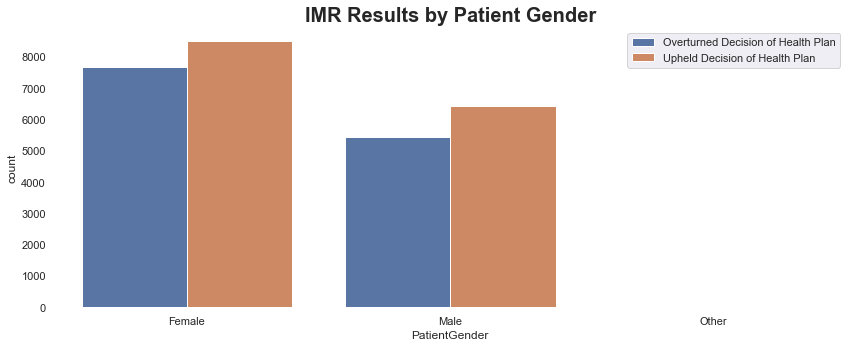

In [9]:
# Determination by Patient Gender
fig, ax = plt.subplots(figsize=(12,5))
g = sns.countplot(x='PatientGender', data=imr2, hue='Determination')
ax.set_title('IMR Results by Patient Gender', fontsize=20, fontweight='bold')
g.legend().set_title(None)
sns.despine(top=True, bottom=True, left=True, right=True)
sns.set(font='Arial')
plt.tight_layout();
ax.grid(color=None, linestyle='None')
ax.set_facecolor('white');

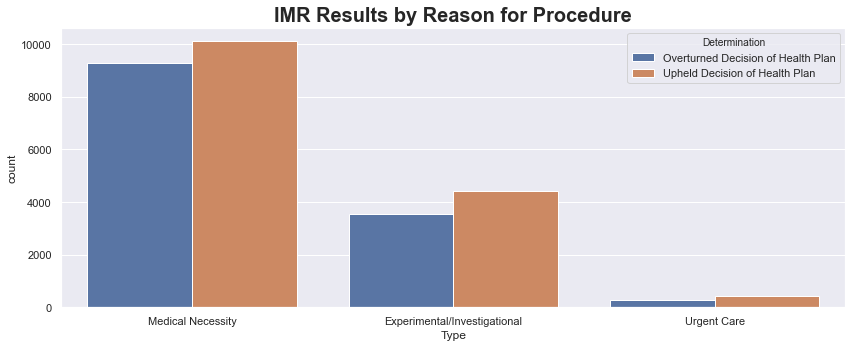

In [10]:
plt.figure(figsize=(12,5))
sns.countplot(x='Type', data=imr2, hue='Determination')
plt.title('IMR Results by Reason for Procedure', fontsize=20, fontweight='bold')
plt.tight_layout();

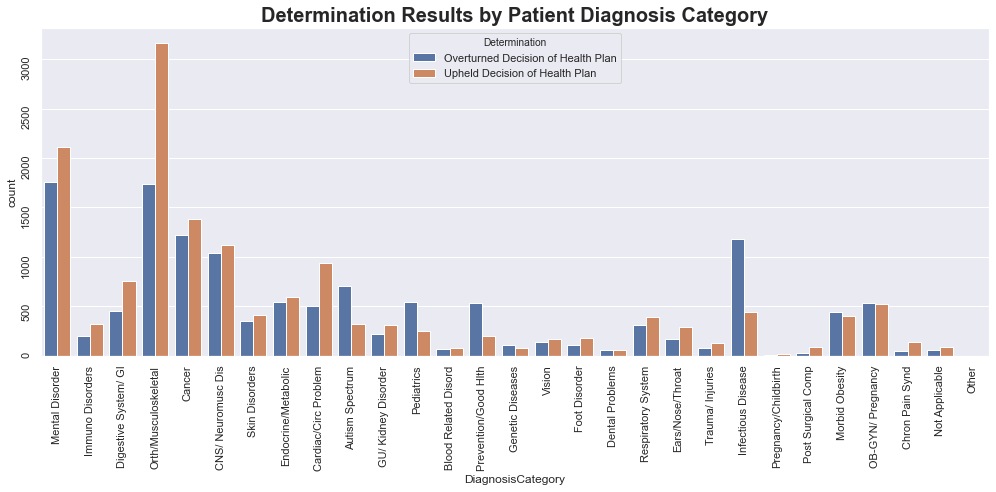

In [11]:
# DETERMINATION RESULTS BY DIAGNOSIS CATEGORY

# Diganosis categories where decisions were overturned more frequently than upheld:
# (1) Austism Spectrum; (2) Pediatrics; (3) Prevention/Good Health; (4) Infectious Disease

# Diagnosis categories where decisions were >=33% MORE LIKELY to be upheld than overturned:
# (1) Digestive System/GI (2) Orthopedic / Muskoskeletal; (3) Cardiac/Circulation Problems; (4) Foot Disorder
fig, ax = plt.subplots(figsize=(14,7))
g = sns.countplot(x='DiagnosisCategory', data=imr2, hue='Determination')
ax.set_title('Determination Results by Patient Diagnosis Category', fontsize=20, fontweight='bold')
ax.tick_params(labelrotation=90)
plt.tight_layout();

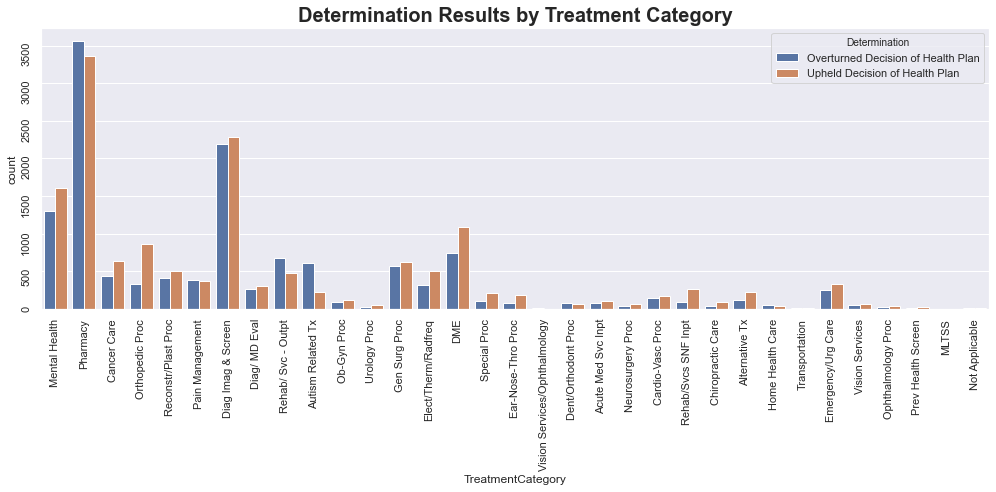

In [12]:
# DETERMINATION RESULTS BY TREATMENT CATEGORY
# DME = Durable Medical Equipment
fig, ax = plt.subplots(figsize=(14,7))
g = sns.countplot(x='TreatmentCategory', data=imr2, hue='Determination')
ax.set_title('Determination Results by Treatment Category', fontsize=20, fontweight='bold')
ax.tick_params(labelrotation=90)
plt.tight_layout();

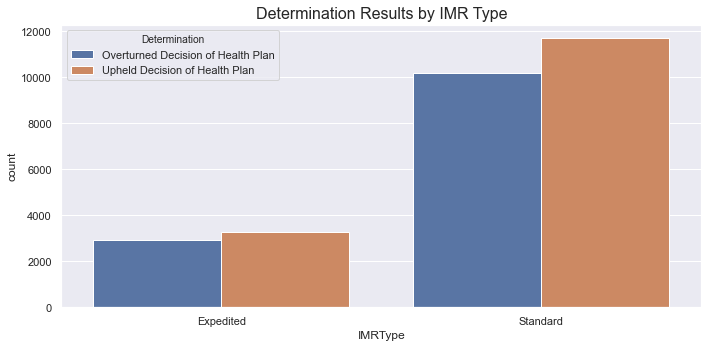

In [13]:
# DETERMINATION RESULTS BY TREATMENT CATEGORY
# DME = Durable Medical Equipment

fig, ax = plt.subplots(figsize=(10,5))
g = sns.countplot(x='IMRType', data=imr2, hue='Determination')
ax.set_title('Determination Results by IMR Type', fontsize=16)

plt.tight_layout();

In [14]:
imr3 = imr2.copy()
imr3['len_findings'] = imr3['Findings'].apply(len)

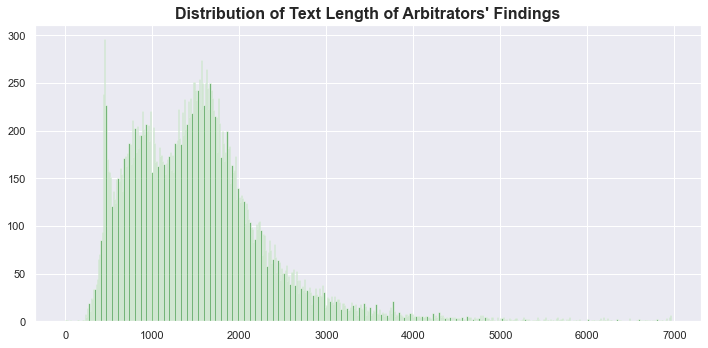

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(imr3['len_findings'], alpha=0.5, color='green', bins=500)
ax.set_title("Distribution of Text Length of Arbitrators' Findings", fontsize=16, fontweight='bold')
ax.grid(b=True, which='minor', linestyle='-')
plt.tight_layout()

---
## Hypothesis Test - Systemic Age Bias in Independent Medical Reviews (IMR) 

**Child** is defined as a patient that is 10 years old or younger.
<br>
**Other-aged patient** is a patient who is 11 years or older.


> $$ p_C = P(\text{Child's denial of service is overturned}) $$
> $$ p_O = P(\text{Other-aged patient's denial of service is overturned}) $$

> $$ H_0: \ p_C = p_O $$

> $$ H_A: \ p_C \neq p_O $$ 

In [16]:
imr3 = imr2.copy()
imr3['determination_encoded'] = imr3['Determination'].map({'Upheld Decision of Health Plan' : 0, 
                                                           'Overturned Decision of Health Plan' : 1})
children = np.asarray(imr3[imr3['AgeRange'] == '11 to 20']['determination_encoded'])
others = np.asarray(imr3[imr3['AgeRange'] != '11 to 20']['determination_encoded'])

In [17]:
mu_h_0 = 0
n_child = len(children)
p_c = sum(children) / n_child

n_others = len(others)
p_o = sum(others) / n_others

p_shared = sum(imr3['determination_encoded']) / len(imr3['determination_encoded'])
var_shared = p_shared * (1 - p_shared) / n_child + p_shared * (1 - p_shared) / n_others
std_err_shared = np.sqrt(var_shared)
# mu for the alternative hypothesis
mu_h_a  = p_c - p_o

# Calculate alternative and null hypotheses distributions.
h_0_dist = stats.norm(mu_h_0, std_err_shared)
h_a_dist = stats.norm(mu_h_a, std_err_shared)

print('Probability for children: {:.4f}'.format(p_c))
print('Probability for all other age: {:.4f}'.format(p_o))
print("Difference in the sample probabilities: {:.4f}".format(mu_h_a))

Probability for children: 0.4877
Probability for all other age: 0.4650
Difference in the sample probabilities: 0.0227


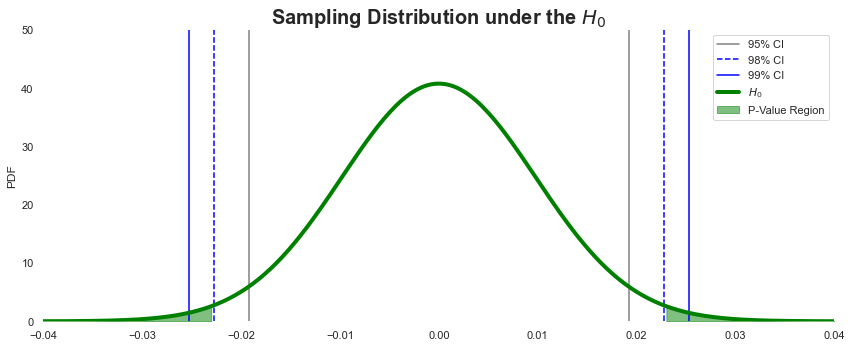

In [18]:
# Calculate and plot p-value
fig, ax = plt.subplots(figsize=(12,5))
x_arr = np.linspace(-0.06, 0.06, 400)

# Calculate and plot 95% CI
up_95_lim = mu_h_0 + 1.96 * std_err_shared
low_95_lim = mu_h_0 - 1.96 * std_err_shared
ax.axvline(up_95_lim, c='grey', linestyle='-', label='95% CI')
ax.axvline(low_95_lim, c='grey', linestyle='-')

# Calculate and plot 98% CI
up_98_lim = mu_h_0 + 2.326 * std_err_shared
low_98_lim = mu_h_0 - 2.326 * std_err_shared
ax.axvline(up_98_lim, c='blue', linestyle='--', label='98% CI')
ax.axvline(low_98_lim, c='blue', linestyle='--')

# Calculate and plot 99% CI
up_99_lim = mu_h_0 + 2.58 * std_err_shared
low_99_lim = mu_h_0 - 2.58 * std_err_shared
ax.axvline(up_99_lim, c='blue', linestyle='-', label='99% CI')
ax.axvline(low_99_lim, c='blue', linestyle='-')

# Plot H0
ax.plot(x_arr, h_0_dist.pdf(x_arr), c='green', label='$H_0$', linewidth=4)

p_val = 1 - h_0_dist.cdf(mu_h_a)
ax.fill_between(x_arr, h_0_dist.pdf(x_arr), where=(x_arr >= mu_h_a), color='green', alpha=0.5, 
                label='P-Value Region')
ax.fill_between(x_arr, h_0_dist.pdf(x_arr), where=(x_arr <= -mu_h_a), color='green', alpha=0.5)
ax.set_title("Sampling Distribution under the $H_0$", fontsize=20, fontweight='bold')
ax.legend(facecolor='white')
ax.set_ylabel('PDF')

# Formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=None, linestyle='None')
ax.set_facecolor('white')
ax.set_xlim(-0.04, 0.04)
ax.set_ylim(0, 50)
plt.rcParams['font.family'] = 'arial'
fig.tight_layout();

#plt.savefig('images/p_val.png')

### Mann-Whitney U Statistics (or Rank-Sum Statistic)

In [19]:
u_stat_mw, p_val_mw = stats.mannwhitneyu(children, others, alternative='two-sided')
print("Mann-Whitney U-Statistic: {:.1f}".format(u_stat_mw))
print("Mann-Whitney P-Value: {:.4f}".format(p_val_mw))

Mann-Whitney U-Statistic: 37313153.0
Mann-Whitney P-Value: 0.0201


### Welch's T-test

In [20]:
var_children = np.var(children)
var_others = np.var(others)

# Signficant difference in sample sizes; therefore, Welch's T-test is appropriate.
print("Children sample variance: {:.4f}".format(var_children))
print("Children sample size: {:.0f}".format(n_child))
print("Others sample variance: {:.4f}".format(var_others))
print("Others sample size: {:.0f}".format(n_others))

Children sample variance: 0.2498
Children sample size: 2897
Others sample variance: 0.2488
Others sample size: 25187


In [21]:
def welch_t_test(sample_1, sample_2):
    num = np.mean(sample_1) - np.mean(sample_2)
    denom = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return num / np.sqrt(denom)

In [22]:
# Reconcile user-defined function's result w/ Scipy module's result.
# Use Welch's t-test's p-value as a check with the Mann-Whitney results.
# If equal_var is True (the default value), then stats.ttest_ind() perfoms the Student's t-test.
t_stat = welch_t_test(children, others)
scipy_t_stat, scipy_p_val =stats.ttest_ind(children, others, equal_var = False)
print("Welch's t-statistic: {:2.4f}".format(t_stat))
print("Scipy's Welch's t-statistic: {:2.4f}".format(scipy_t_stat))
print("Scipy's Welch's t-statistic: {:2.4f}".format(scipy_p_val))

Welch's t-statistic: 2.3198
Scipy's Welch's t-statistic: 2.3195
Scipy's Welch's t-statistic: 0.0204


---
## Statistical Power

$$ \text{Power} = P( \text{Reject } H_0 \mid H_0 \text{ is false}) $$


alpha = 0.025
beta = 0.358


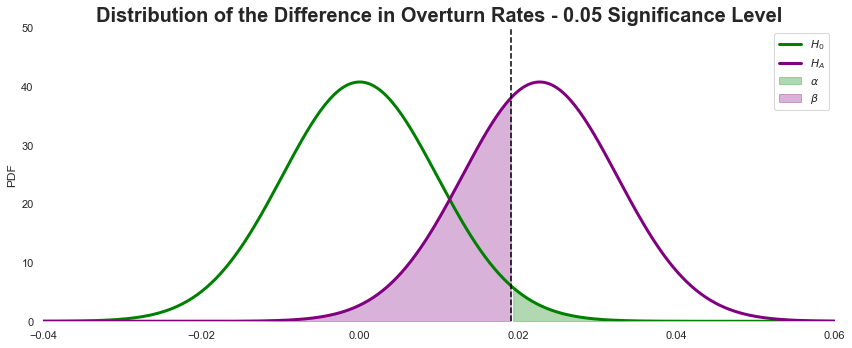

In [23]:
# Possible significance levels('sig_lev') are 0.01, 0.02, and 0.05.
sig_lev = 0.05
sl_dict ={0.05: up_95_lim, 0.02: up_98_lim, 0.01: up_99_lim}
alpha = sig_lev / 2
beta = h_a_dist.cdf(sl_dict[sig_lev])

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(x_arr, h_0_dist.pdf(x_arr), c='green', label='$H_0$', linewidth=3)

#Plot alternative hypothesis
ax.plot(x_arr, h_a_dist.pdf(x_arr), c='purple', label='$H_A$', linewidth=3)

ax.axvline(sl_dict[sig_lev], c='black', linestyle='--')
ax.fill_between(x_arr, h_0_dist.pdf(x_arr), where=(x_arr >= sl_dict[sig_lev]), color='green', alpha=0.3, label=r'$\alpha$')
ax.fill_between(x_arr, h_a_dist.pdf(x_arr), where=(x_arr <= sl_dict[sig_lev]), color='purple', alpha=0.3, label=r'$\beta$')

ax.set_title('Distribution of the Difference in Overturn Rates - {:.2} Significance Level'.format(sig_lev), 
             fontsize=20, fontweight='bold')
ax.set_ylabel('PDF')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=None, linestyle='None')
ax.set_facecolor('white')
ax.set_xlim([-0.04,0.06])
ax.set_ylim([0,50])
plt.rcParams['font.family'] = 'arial'
fig.tight_layout();
ax.legend(facecolor='white');


print('alpha = {:.3f}'.format(alpha))
print('beta = {:.3f}'.format(beta))

#plt.savefig("images/alpha_beta.png")

Power = 0.642


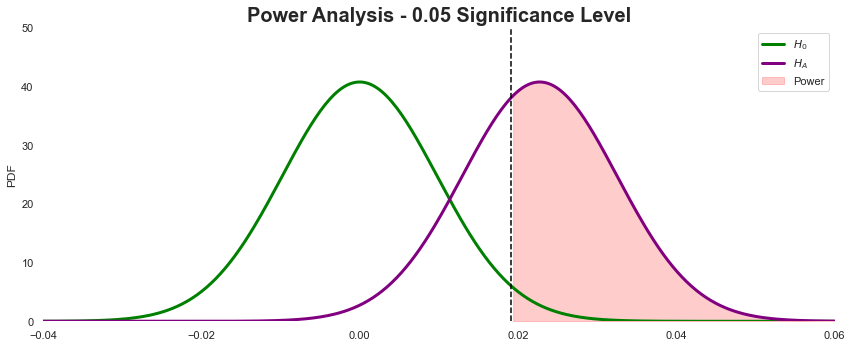

In [24]:
power = 1 - h_a_dist.cdf(sl_dict[sig_lev])

fig, ax = plt.subplots(figsize=(12,5))

# Plot null hypothesis.
ax.plot(x_arr, h_0_dist.pdf(x_arr), c='green', label='$H_0$', linewidth=3)

#Plot alternative hypothesis
ax.plot(x_arr, h_a_dist.pdf(x_arr), c='purple', label='$H_A$', linewidth=3)
ax.axvline(sl_dict[sig_lev], c='black', linestyle='--')
ax.fill_between(x_arr, h_a_dist.pdf(x_arr), where=(x_arr >= sl_dict[sig_lev]), color='red', alpha=0.2, label='Power')
ax.set_title('Power Analysis - {:.2} Significance Level'.format(sig_lev), fontsize=20, fontweight='bold')
ax.set_ylabel('PDF')

# Formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=None, linestyle='None')
ax.set_facecolor('white')
ax.set_xlim([-0.04,0.06])
ax.set_ylim([0,50])
fig.tight_layout()
ax.legend()
plt.rcParams['font.family'] = 'arial'
ax.legend(facecolor='white');

print('Power = {:.3f}'.format(power))

#plt.savefig("images/power.png")

---
## Bayesian Inference 

In [25]:
# Children
alpha_bayes_child = sum(children) + 1
beta_bayes_child = n_child - sum(children) + 1
posterior_dist_child = stats.distributions.beta(alpha_bayes_child, beta_bayes_child)

# Others
alpha_bayes_others = sum(others) + 1
beta_bayes_others = n_others - sum(others) + 1
posterior_dist_others = stats.distributions.beta(alpha_bayes_others, beta_bayes_others)

Children's sample size: 2897
Others' sample size: 25187


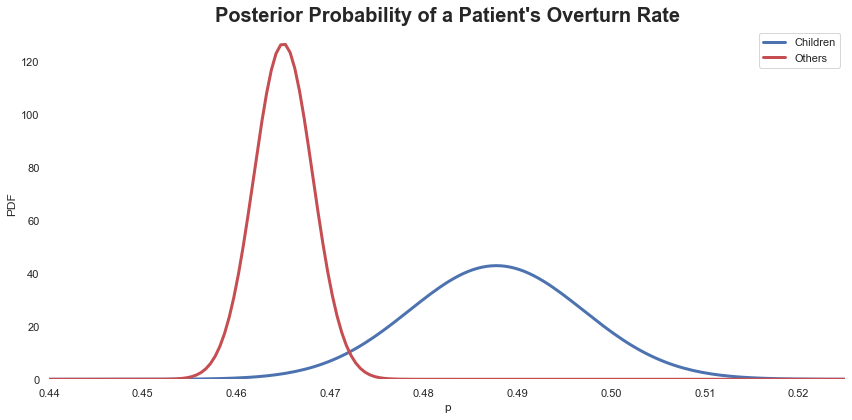

In [26]:
fig, ax = plt.subplots(figsize=(12,6))

x_arr2 = np.linspace(0, 1, 2000)
ax.plot(x_arr2, posterior_dist_child.pdf(x_arr2), color='b', label='Children', linewidth=3)
ax.plot(x_arr2, posterior_dist_others.pdf(x_arr2), color='r', label='Others', linewidth=3)
ax.legend()
ax.set_title("Posterior Probability of a Patient's Overturn Rate", fontsize=20, fontweight='bold')
ax.set_xlabel('p')
ax.set_ylabel('PDF')
ax.set_ylim(ymin=0)
ax.set_xlim(0.44, 0.525);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color=None, linestyle='None')
ax.set_facecolor('white')
fig.tight_layout()
ax.legend()
plt.rcParams['font.family'] = 'arial'
ax.legend(facecolor='white');

print ("Children's sample size: {}".format(n_child))
print("Others' sample size: {}".format(n_others))

plt.savefig("images/bayes_test.png", bbox_inches="tight")

### Simulation to Quantify the Difference in Overturn Rate for the Two Age Group

In [27]:
samp_child = posterior_dist_child.rvs(size=100000)
samp_others = posterior_dist_others.rvs(size=100000)
sim_mean = round((samp_child > samp_others).mean()*100,1)

print("{:.1f}% likelihood that a child's expected overturn rate is greater than older patients.".format(sim_mean))

99.0% likelihood that a child's expected overturn rate is greater than older patients.
